## Projecting Cohort Fertility Rates

This notebook uses PyMC to model and predict fertility rates in the United States, using data from the National Survey of Family Growth (NSFG).

Background article on fertility rates: "[Why the total fertility rate doesn't necessarily tell us the number of births women eventually have](https://ourworldindata.org/total-fertility-rate-births-per-woman)" 

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/BayesFertility/blob/main/fertility_nsfg.ipynb)

In the most recent NSFG data, we see that women born in the 1990s and 2000s have borne fewer babies than women in previous cohorts when they were observed at the same age.
To the degree that their lower fertility reflects their preferences, we would expect their Cohort Completed Fertility Rate (CFR) to be lower as well.
On the other hand, if their lower fertility reflects their circumstances, these cohorts might have higher fertility in the future, which might allow them to catch up with previous generations, partially or completely.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/BayesFertility/raw/main/utils.py")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

from utils import decorate, value_counts

In [3]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [6.75, 3.5]

# AIBM brand colors
aibm_light_gray = "#F3F4F3"
aibm_medium_gray = "#767676"
aibm_green = "#0B8569"
light_green = "#AAC9B8"
aibm_orange = "#C55300"
light_orange = "#F4A26B"
aibm_purple = "#9657A5"
light_purple = "#CFBCD0"
aibm_blue = "#4575D6"
light_blue = "#C9D3E8"

# additional colors from coolers.co
dark_gray = "#404040"
dark_purple = "#28112B"
dark_green = "#002500"
amber = "#F5BB00"
oxford_blue = "#000022"
bittersweet = "#FF6666"
crimson = "#D62839"

# tick and label colors
plt.rcParams["axes.edgecolor"] = aibm_medium_gray  # Spines (axis border)
plt.rcParams["xtick.color"] = aibm_medium_gray  # X-axis ticks
plt.rcParams["ytick.color"] = aibm_medium_gray  # Y-axis ticks
plt.rcParams["axes.labelcolor"] = aibm_medium_gray  # Axis labels

# remove all spines
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

# light gray horizontal grid lines
plt.rcParams["grid.color"] = aibm_light_gray
plt.rcParams["grid.linestyle"] = "-"  # Solid lines
plt.rcParams["grid.linewidth"] = 1  # Thin lines
plt.rcParams["axes.grid"] = True  # Enable grid
plt.rcParams["axes.grid.axis"] = "y"  # Apply only to horizontal lines

# Remove tick marks
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["ytick.minor.size"] = 0

# Use PT Sans as the default font
# plt.rcParams["font.family"] = "PT Sans"

## Data

The dataset I'm using is an excerpt I prepared in [this GitHub repository](https://github.com/AllenDowney/MarriageNSFG).
It combines data from multiple iterations of the NSFG, starting in 1982 and including the most recent data collected in 2022-23.

In [4]:
download(
    "https://github.com/AllenDowney/MarriageNSFG/raw/refs/heads/main/FemMarriageData.hdf"
)

In [5]:
df = pd.read_hdf("FemMarriageData.hdf", "FemMarriageData")
df.shape

(75769, 49)

The primary variable we'll use is `parity`, which is a recoded variable available for all respondents, that indicates the respondents number of live births.

In [6]:
value_counts(df["parity"])

,counts
values,
0.0,32395
1.0,13876
2.0,15857
3.0,8539
4.0,3227
5.0,1127
6.0,440
7.0,172
8.0,79


A few of these values are large enough to be suspect.
I tested the effect of trimming exceptionally large values, but it has no visible effect on the results, so I'm inclined to leave the data alone.

In [7]:
df.query("parity > 12")[["cycle", "parity", "finalwgt"]]

,cycle,parity,finalwgt
14128,10,14.0,4391.925354
40451,7,15.0,8213.416490
41575,6,22.0,4572.017466
46199,6,16.0,1537.629557
71173,3,13.0,13607.000000


In [8]:
if False:
    trimmed = df["parity"] > 12
    df.loc[trimmed, "parity"] = 12

I'll group respondents into groups by year of birth and age when they were interviewed.
In both dimensions, the width of these bins is three years.
The label on each bin is the midpoint.

In [9]:
from utils import round_into_bins

df["age_group"] = round_into_bins(df["ager"], 3, low=14, high=47) + 1

In [10]:
df.groupby("age_group")["ager"].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
15,4549.0,15.897633,0.579322,14.833333,15.416667,16.000000,16.333333,16.916667
18,8041.0,18.378819,0.868988,17.000000,17.666667,18.333333,19.000000,19.916667
21,6897.0,21.402554,0.876886,20.000000,20.666667,21.416667,22.083333,22.916667
24,7542.0,24.392546,0.870031,23.000000,23.666667,24.333333,25.083333,25.916667
27,7977.0,27.358050,0.870404,26.000000,26.666667,27.333333,28.000000,28.916667
30,8387.0,30.359743,0.869695,29.000000,29.666667,30.333333,31.000000,31.916667
33,7972.0,33.321814,0.877545,32.000000,32.583333,33.250000,34.000000,34.916667
36,7334.0,36.341855,0.879642,35.000000,35.583333,36.333333,37.000000,37.916667
39,6653.0,39.347876,0.877302,38.000000,38.583333,39.333333,40.000000,40.916667


In [11]:
pd.crosstab(df["age_group"], df["cycle"])

cycle,3,4,5,6,7,8,9,10,11,12
age_group,,,,,,,,,,
15,569,440,547,433,842,375,362,362,363,256
18,1319,780,862,708,1427,660,642,562,607,474
21,904,780,865,808,1255,558,530,394,439,364
24,864,841,963,816,1293,599,661,542,574,389
27,923,945,1011,775,1445,635,611,554,605,473
30,882,1022,1223,827,1395,657,621,547,626,587
33,766,1018,1340,790,1120,555,611,520,628,624
36,601,914,1292,799,1090,505,562,475,537,559
39,528,783,1243,724,1064,450,448,408,458,547


In [12]:
df["birth_group"] = round_into_bins(df["year"], 3, low=0) + 1

In [13]:
df.groupby("birth_group")["year"].describe()

,count,mean,std,min,25%,50%,75%,max
birth_group,,,,,,,,
37,179.0,37.815642,0.388863,37.0,38.0,38.0,38.0,38.0
40,460.0,40.021739,0.810850,39.0,39.0,40.0,41.0,41.0
43,882.0,43.202948,0.759856,42.0,43.0,43.0,44.0,44.0
46,1380.0,46.070290,0.818647,45.0,45.0,46.0,47.0,47.0
49,1811.0,49.143567,0.834568,48.0,48.0,49.0,50.0,50.0
52,2968.0,52.028302,0.814352,51.0,51.0,52.0,53.0,53.0
55,3170.0,55.021451,0.810654,54.0,54.0,55.0,56.0,56.0
58,3714.0,58.037695,0.797708,57.0,57.0,58.0,59.0,59.0
61,3992.0,61.052605,0.825998,60.0,60.0,61.0,62.0,62.0


In [14]:
pd.crosstab(df["birth_group"], df["cycle"])

cycle,3,4,5,6,7,8,9,10,11,12
birth_group,,,,,,,,,,
37,179,0,0,0,0,0,0,0,0,0
40,460,0,0,0,0,0,0,0,0,0
43,519,363,0,0,0,0,0,0,0,0
46,626,754,0,0,0,0,0,0,0,0
49,765,820,226,0,0,0,0,0,0,0
52,887,921,1160,0,0,0,0,0,0,0
55,916,1018,1236,0,0,0,0,0,0,0
58,865,997,1296,556,0,0,0,0,0,0
61,908,965,1310,712,97,0,0,0,0,0


## Reweighting

The NSFG uses stratified sampling, some groups are deliberately oversampled.
For each respondent, the `finalwgt` column provides a sampling weight we can use to correct for stratified sampling.

If we summarize the distribution of sampling weights in each cycle, we can see that the range of weights is generally quite wide, and also that the magnitudes of the weights are different in different cycles -- which suggests that they used a different weighting system during different iterations.

As a result, we should be careful not to combine weights from different cycles.

In [15]:
df.groupby("cycle")["finalwgt"].describe()

,count,mean,std,min,25%,50%,75%,max
cycle,,,,,,,,
3,7969.0,67886.793450,62766.997833,6022.000000,16643.000000,37818.000000,104203.000000,6.588880e+05
4,8450.0,685207.105089,419209.971920,19741.000000,326658.000000,709094.500000,888281.000000,5.499660e+06
5,10847.0,5549.977323,2668.618457,349.876100,3648.050800,5534.631900,6642.457950,3.354982e+04
6,7643.0,8054.522410,7342.734883,118.656790,4175.880599,6553.169964,9590.027246,2.618800e+05
7,12279.0,5029.297260,5527.506822,41.084436,1577.777464,3040.704205,6087.405502,3.022635e+04
8,5601.0,10870.802178,12606.086581,1714.541000,4143.177321,6744.820880,12344.571351,8.520795e+04
9,5699.0,10789.922092,11292.680457,1859.105000,4382.507056,7124.422412,12611.500388,7.539941e+04
10,5554.0,13002.896291,15811.370555,1924.916000,4641.329178,7513.585309,14818.169985,1.067744e+05
11,6141.0,11833.891223,13074.819563,1340.862000,4246.620623,7464.253280,13868.904073,8.333213e+04


We can use this function to compute a weighted resampling of the entire dataset.

In [16]:
from utils import resample_by_cycle

np.random.seed(77)
sample = resample_by_cycle(df)

To see whether the resampling makes much of a difference, we'll compute the mean of `parity` in each age group and birth group, and compare the results with and without resampling.

In [17]:
def compare_parity(df, sample, col):
    """
    """
    unsampled = df.groupby(col)["parity"].mean()
    sampled = sample.groupby(col)["parity"].mean()

    unsampled.plot(label="unsampled")
    sampled.plot(label="sampled")
    decorate(ylabel="Mean parity")

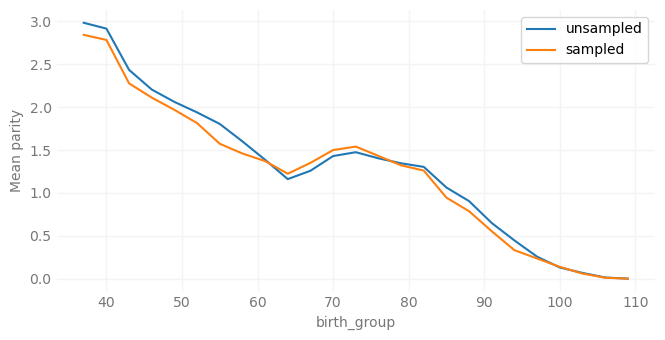

In [18]:
compare_parity(df, sample, "birth_group")

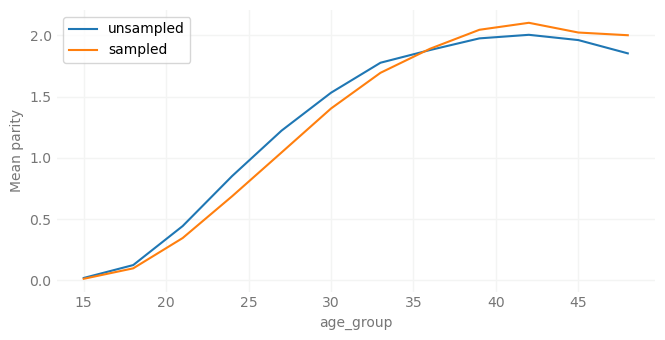

In [19]:
compare_parity(df, sample, "age_group")

Across birth groups and age groups, the differences in average parity -- with and without resampling -- are non-negligible.
So we'll need to take the sampling design into account.

## Prepare the data

The following function takes a `DataFrame` and returns aggregated parity data in the form we need for inference: `count_df` contains the number of women in each age-cohort group, and `sum_df` reports the total parity of all women in each group.

In [20]:
def prepare_data(df, weighted=False):
    """Prepares aggregated parity data.

    df: DataFrame containing 'birth_group', 'age_group', 'parity', and 'finalwgt'.
    weighted: bool, whether to weight the parity values by 'finalwgt'.

    Returns:
        sum_df: DataFrame with weighted sum of parity per cohort.
        count_df: DataFrame with count of parity observations per cohort.
    """
    if weighted:
        weights = df["finalwgt"] / df["finalwgt"].mean()
        df["weighted_parity"] = df["parity"] * weights
    else:
        df["weighted_parity"] = df["parity"]

    # Aggregate weighted sum and weighted count at birth_group and age_group level
    table = (
        df.groupby(["birth_group", "age_group"])["weighted_parity"]
        .agg(["sum", "count"])
        .unstack()
    )

    # Create a shared cohort index
    cohort_labels = [1900 + cohort for cohort in table.index]
    cohort_index = pd.Index(cohort_labels, name="cohort")

    # Create sum and count tables with the shared index
    sum_df = table["sum"].set_index(cohort_index)
    count_df = table["count"].fillna(0).set_index(cohort_index)

    return sum_df, count_df

Here are the results for the unweighted and resampled data. 

In [21]:
sum_df_unweighted, count_df_unweighted = prepare_data(df)

In [22]:
sum_df_sample, count_df_sample = prepare_data(sample)

The following function weights the data explicitly rather than by random resampling.
It breaks the dataset into cycles, weights each cycle using normalized weights, and then combines the results into the two `DataFrames`.

In [23]:
from functools import reduce


def weight_by_cycle(df):
    """
    """
    sum_dfs = []
    count_dfs = []

    # loop through cycles
    for name, group in df.groupby("cycle"):
        sum_df, count_df = prepare_data(group, weighted=True)
        sum_dfs.append(sum_df)
        count_dfs.append(count_df)

    def add_dfs(dfs):
        return reduce(lambda x, y: x.add(y, fill_value=0), dfs)

    sum_df = add_dfs(sum_dfs)
    count_df = add_dfs(count_dfs).fillna(0)

    return sum_df, count_df

In [24]:
sum_df_weighted, count_df_weighted = weight_by_cycle(df)
sum_df_weighted.head()

age_group,15,18,21,24,27,30,33,36,39,42,45,48
cohort,,,,,,,,,,,,
1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.910324,508.821234,NaN
1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.407306,1532.562929,11.728968,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.991977,1447.473006,300.883790,562.191752,NaN
1946,NaN,NaN,NaN,NaN,NaN,NaN,92.173789,1507.344386,412.660544,1183.598114,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,48.562538,1426.529168,431.908001,1184.799489,NaN,438.661298,NaN


Now we can select with version of the data to use for the rest of this notebook.
My first choice would be the explicitly weighted data, because it's not random -- but it's possible that I've done something wrong in computing it, because it yields results that are implausible in a few places (but not far off).

The results with the resampled data are more plausible, and they don't vary much from one sampling to another.
So that's what I'm using for now.

In [25]:
sum_df = sum_df_unweighted
count_df = count_df_unweighted

In [26]:
sum_df = sum_df_weighted
count_df = count_df_weighted

In [27]:
sum_df = sum_df_sample
count_df = count_df_sample

In [28]:
sum_df.head(10)

age_group,15,18,21,24,27,30,33,36,39,42,45,48
cohort,,,,,,,,,,,,
1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,490.0,NaN
1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,1408.0,6.0,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,1501.0,316.0,564.0,NaN
1946,NaN,NaN,NaN,NaN,NaN,NaN,113.0,1441.0,378.0,1211.0,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,39.0,1477.0,458.0,1210.0,NaN,422.0,NaN
1952,NaN,NaN,NaN,NaN,76.0,1342.0,350.0,1184.0,NaN,2059.0,209.0,NaN
1955,NaN,NaN,NaN,34.0,1072.0,407.0,1189.0,NaN,2027.0,181.0,NaN,NaN
1958,NaN,NaN,31.0,668.0,242.0,1055.0,NaN,1950.0,203.0,691.0,482.0,NaN
1961,NaN,18.0,328.0,175.0,780.0,NaN,1873.0,228.0,898.0,1099.0,238.0,NaN


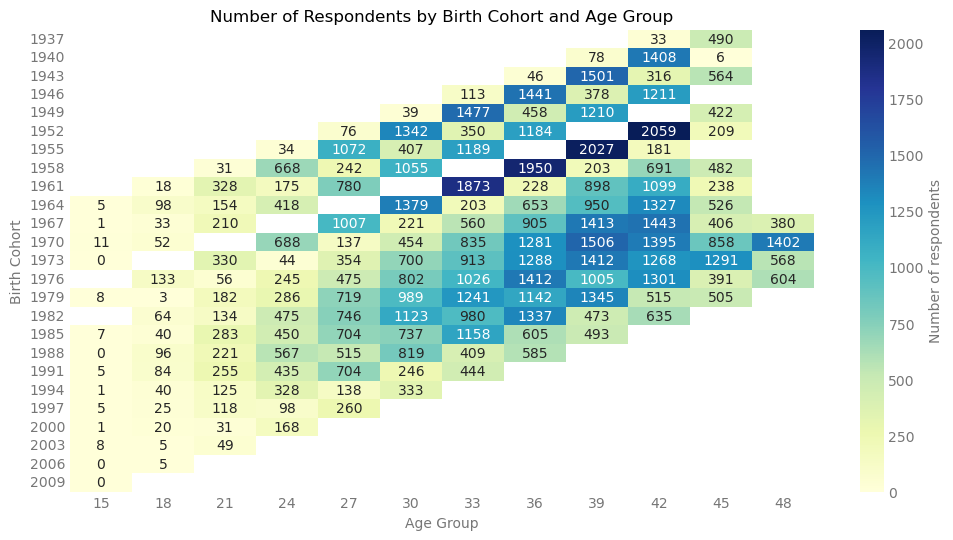

In [29]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    sum_df,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "Number of respondents"},
)

plt.title("Number of Respondents by Birth Cohort and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Birth Cohort")
plt.grid(False)

In [30]:
count_df.head(30)

age_group,15,18,21,24,27,30,33,36,39,42,45,48
cohort,,,,,,,,,,,,
1937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,169.0,0.0
1940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,498.0,3.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,648.0,154.0,249.0,0.0
1946,0.0,0.0,0.0,0.0,0.0,0.0,46.0,695.0,183.0,565.0,0.0,0.0
1949,0.0,0.0,0.0,0.0,0.0,28.0,760.0,216.0,619.0,0.0,209.0,0.0
1952,0.0,0.0,0.0,0.0,43.0,853.0,211.0,623.0,0.0,1052.0,97.0,0.0
1955,0.0,0.0,0.0,44.0,933.0,234.0,759.0,0.0,1056.0,96.0,0.0,0.0
1958,0.0,0.0,44.0,856.0,206.0,737.0,0.0,1119.0,107.0,326.0,252.0,0.0
1961,0.0,40.0,866.0,228.0,749.0,0.0,1139.0,109.0,399.0,487.0,96.0,0.0


I'll extract the age and cohort labels for use later in the notebook.

In [31]:
age_labels = sum_df.columns.astype(int).values
cohort_labels = sum_df.index.astype(int).values

## The Model

For the most recent generations, we have limited data.
To project what future fertility rates will look like, we'll use a model to estimate cohort and age effects, then use the model to generate predictions.

The following PyMC model is based on a log-linear model of age cohort effects -- that is, each cohort has a latent value, $\alpha$, that indicates their overall proclivity to have children, and each age group has a latent value, $\beta$, that indicates the tendency of people to have children at that age.

The average number of children borne by a particular cohort during a given 3-year span is $\lambda = \exp \alpha + \beta$.
So the average parity of a cohort at a given age is the cumulative sum of these rates up to their current age.

Both $\alpha$ and $\beta$ are modeled with a Gaussian random walk, which indicates that we expect the difference between successive cohorts, and between successive age groups, to follow a Gaussian distribution.
As a result, each values is estimated relative to its predecessor, so in the absence of enough data to infer a chance, each value is presumed to be unchanged.
We'll see the consequences of this structure in the results.

The values of $\alpha$ are constrained so their mean is 0.
This is useful because the location of the $\alpha$ and $\beta$ coefficients is arbitrary; this constraint establishes a zero point.

Finally, if we are given the size and expected parity of a cohort-age group, we expect the observed data to follow a Poisson distribution with the given mean.

In [32]:
cohorts, ages = sum_df.shape
count_array = count_df.to_numpy()
sum_array = sum_df.to_numpy()

In [33]:
with pm.Model() as model1:
    # Random walk prior for cohort effects with mean constraint
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=0.1)
    alpha_raw = pm.GaussianRandomWalk(
        "alpha_raw",
        sigma=sigma_alpha,
        shape=cohorts,
        init_dist=pm.Normal.dist(mu=0, sigma=0.4),
    )

    # Constrain alpha to have mean 0
    alpha = pm.Deterministic("alpha", alpha_raw - pm.math.mean(alpha_raw))

    # Random walk prior for age effects
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.1)
    beta = pm.GaussianRandomWalk(
        "beta", sigma=sigma_beta, shape=ages, init_dist=pm.Normal.dist(mu=0, sigma=0.4)
    )

    # Log-linear model for the ASBR
    log_lambda = alpha[:, None] + beta[None, :]
    lambda_ = pm.Deterministic("lambda", pm.math.exp(log_lambda))

    # Observed parity depends on the cumulative sum of ASBRs
    cumulative_lambda = pm.math.cumsum(lambda_, axis=1)

    # Likelihood, ignoring unobserved cohort-age pairs
    mask = count_array != 0
    y_obs = pm.Poisson(
        "y_obs", mu=(count_array * cumulative_lambda)[mask], observed=sum_array[mask]
    )

In [34]:
import pymc as pm
import numpy as np

cohorts, ages = sum_df.shape
count_array = count_df.to_numpy()
sum_array = sum_df.to_numpy()

# Create an age index centered at its mean
age_index = np.arange(ages) - np.mean(np.arange(ages))

with pm.Model() as model2:
    # Random walk prior for cohort effects with mean constraint
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=0.1)
    alpha_raw = pm.GaussianRandomWalk(
        "alpha_raw",
        sigma=sigma_alpha,
        shape=cohorts,
        init_dist=pm.Normal.dist(mu=0, sigma=0.4),
    )
    alpha = pm.Deterministic("alpha", alpha_raw - pm.math.mean(alpha_raw))

    # Random walk prior for age effects
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.1)
    beta = pm.GaussianRandomWalk(
        "beta", sigma=sigma_beta, shape=ages, init_dist=pm.Normal.dist(mu=0, sigma=0.4)
    )

    # Interaction term (cohort-age interaction effect)
    gamma = pm.Normal("gamma", mu=0, sigma=0.2)  # Allows positive or negative shifts
    interaction = pm.Deterministic(
        "interaction", gamma * alpha[:, None] * age_index[None, :]
    )

    # Log-linear model for the ASBR with cohort-age interaction
    log_lambda = alpha[:, None] + beta[None, :] + interaction
    lambda_ = pm.Deterministic("lambda", pm.math.exp(log_lambda))

    # Observed parity depends on the cumulative sum of ASBRs
    cumulative_lambda = pm.math.cumsum(lambda_, axis=1)

    # Likelihood, ignoring unobserved cohort-age pairs
    mask = count_array != 0
    y_obs = pm.Poisson(
        "y_obs", mu=(count_array * cumulative_lambda)[mask], observed=sum_array[mask]
    )

To see whether the prior distributions make sense, we'll look at the prior predictive distribution of $\lambda$.

In [35]:
model = model1

In [36]:
with model:
    prior_predictive = pm.sample_prior_predictive(100)

lambda_prior_samples = (
    prior_predictive.prior["lambda"].stack(sample=("chain", "draw")).values
)

Sampling: [alpha_raw, beta, sigma_alpha, sigma_beta, y_obs]


In [37]:
pd.Series(lambda_prior_samples.flatten()).describe()

count    30000.000000
mean         1.074053
std          0.685345
min          0.173122
25%          0.651024
50%          0.899898
75%          1.314472
max          9.945637
dtype: float64

Now let's sample the posterior distribution.
In general, the model samples well.

In [44]:
import arviz as az
import os

def run_or_load_idata(run_model: bool, model: pm.Model, filename: str, **sample_kwargs) -> az.InferenceData:
    """
    Runs PyMC sampling and saves the results to a NetCDF file, or loads existing results from the file.

    This function either:
    - Runs the sampling procedure and saves the idata to a compressed NetCDF file.
    - Or loads the existing idata from the file if `run_model` is False and the file exists.

    Args:
        run_model (bool): 
            Whether to run the sampling process (`True`) or load from file (`False`).
        model (pm.Model): 
            The PyMC model object to sample from.
        filename (str): 
            Path to the NetCDF file to save to or load from.
        **sample_kwargs: 
            Additional keyword arguments passed directly to `pm.sample()`.

    Returns:
        az.InferenceData: 
            The idata (posterior samples) as an ArviZ InferenceData object.

    """
    if run_model or not os.path.exists(filename):
        with model:
            idata = pm.sample(**sample_kwargs)

        az.to_netcdf(idata, filename)
        print(f"Saved new idata to {filename}")

    else:
        idata = az.from_netcdf(filename)
        print(f"Loaded idata from {filename}")

    return idata


In [46]:
idata = run_or_load_idata(False, model, 'fertility_nsfg_idata', draws=500, random_seed=17)

Loaded idata from fertility_nsfg_idata


It throws a warning about effective sample sizes, but it looks like that's just for the raw parameters.
And that's OK because we expect them to be unconstrained prior to being unbiased.
The other parameters have good diagnostics.

### Cohort effects

Here is a summary of the cohort effects.

In [47]:
alpha_summary = pm.summary(idata, var_names=["alpha"], hdi_prob=0.94)
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.533,0.043,0.460,0.625,0.001,0.001,1704.0,1544.0,1.0
alpha[1],0.513,0.030,0.456,0.567,0.001,0.001,1660.0,1638.0,1.0
alpha[2],0.332,0.026,0.281,0.378,0.001,0.000,2011.0,1778.0,1.0
alpha[3],0.275,0.024,0.232,0.321,0.001,0.000,1620.0,1569.0,1.0
alpha[4],0.247,0.023,0.204,0.290,0.000,0.000,2324.0,1499.0,1.0
alpha[5],0.203,0.021,0.165,0.242,0.000,0.000,1956.0,1429.0,1.0
alpha[6],0.168,0.021,0.127,0.207,0.001,0.000,1794.0,1704.0,1.0
alpha[7],0.157,0.021,0.120,0.198,0.000,0.000,2006.0,1471.0,1.0
alpha[8],0.211,0.021,0.175,0.252,0.000,0.000,1974.0,1477.0,1.0
alpha[9],0.169,0.021,0.131,0.208,0.000,0.000,1978.0,1397.0,1.0


In [48]:
def forest_plot(summary, labels, **options):
    means = summary["mean"].values
    hdi_lower = summary["hdi_3%"].values
    hdi_upper = summary["hdi_97%"].values

    num_cohorts = len(means)
    x_positions = np.arange(num_cohorts)
    plt.xticks(x_positions, labels, **options)

    plt.errorbar(
        x_positions,
        means,
        yerr=[means - hdi_lower, hdi_upper - means],
        fmt="o",
        markersize=4,
        capsize=2,
        color="C0",
    )

And here's what they look like:

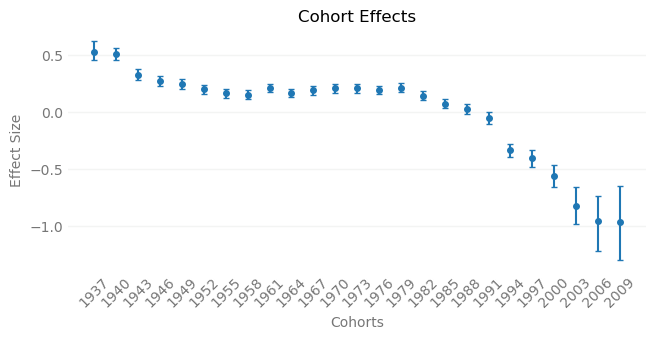

In [49]:
forest_plot(alpha_summary, cohort_labels, rotation=45)
plt.ylabel("Effect Size")
plt.xlabel("Cohorts")
plt.title("Cohort Effects")
plt.tight_layout()

Qualitatively, the trend is what we expect to see.
The proclivity to have children is highest in the 1937 and 1940 cohorts, who had their babies at the tail end of the baby boom.
It's mostly unchanged from 1943 to 1982, declines slowly until 1991, and then declines more quickly.

The error bars are wider in the most recent cohorts, where we have less data.
In the most recent cohorts, we see a useful property of the random walk -- if there is not enough data to be confident that there is a change, it assumes that there is no change.
For example, the central estimates for the 2006 and 2009 cohorts are about the same, because there is not enough data in the 2009 cohort to provide strong evidence of a difference.

This is different from what we would see in a hierarchical model, where in the absence of sufficient data, estimates are centered on the overall mean, not the most recent mean.

The model is conservative in the sense that it does not extrapolate trends -- although it looks like this proclivity has declined consistently over the last 30 years, the model does not assume that this trend will continue.

### Age effects

Here is a summary of the age effects.

In [50]:
beta_summary = pm.summary(idata, var_names=["beta"], hdi_prob=0.94)
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-3.856,0.101,-4.050,-3.666,0.002,0.001,2484.0,1653.0,1.0
beta[1],-2.506,0.053,-2.597,-2.401,0.001,0.001,1939.0,1289.0,1.0
beta[2],-1.447,0.036,-1.511,-1.376,0.001,0.001,2123.0,1567.0,1.0
beta[3],-1.181,0.040,-1.251,-1.103,0.001,0.001,2049.0,1383.0,1.0
beta[4],-1.232,0.053,-1.335,-1.141,0.001,0.001,1970.0,1508.0,1.0
beta[5],-1.253,0.058,-1.361,-1.145,0.001,0.001,1921.0,1429.0,1.0
beta[6],-1.595,0.083,-1.753,-1.447,0.002,0.001,1654.0,1386.0,1.0
beta[7],-1.950,0.112,-2.155,-1.742,0.003,0.002,1730.0,1374.0,1.0
beta[8],-2.802,0.200,-3.171,-2.435,0.004,0.003,2175.0,1190.0,1.0
beta[9],-3.920,0.303,-4.495,-3.371,0.008,0.005,1673.0,1386.0,1.0


And here's what they look like.

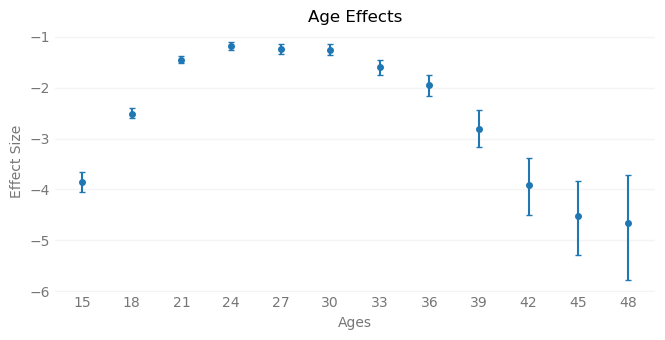

In [51]:
forest_plot(beta_summary, age_labels)

plt.ylabel("Effect Size")
plt.xlabel("Ages")
plt.title("Age Effects")
plt.tight_layout()

Qualitatively, the trends here are what we expect: women are most likely to have children when they are 21-33 years old.

In the age groups where we have less data, the error bars are wider.
And again, the model does not extrapolate trends, so the estimates level off in the oldest groups.

### Cohort-age interactions

In [52]:
if model is model2:
    gamma_summary = pm.summary(idata, var_names=["gamma"], hdi_prob=0.94)

And here's what they look like.

In [53]:
if False:
    forest_plot(gamma_summary, cohort_labels, rotation=45)
    plt.ylabel("Effect Size")
    plt.xlabel("Cohort")
    plt.title("Cohort-Age interactions")
    plt.tight_layout()

## Prediction

Now we can use the model to generate predictive distributions for each cohort-age group, including retrodictions for the groups where we have data, and predictions for the groups where we have little or none.

In [54]:
with model:
    # Generate posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(
        idata, var_names=["lambda"], random_seed=42
    )

    # Compute expected cumulative births for each draw
    lambda_samples = posterior_predictive.posterior_predictive[
        "lambda"
    ].values  # Shape: (chains, draws, cohorts, ages)

    cumulative_lambda_pred = np.cumsum(
        lambda_samples, axis=-1
    )  # Compute cumulative sum along age axis

Sampling: []


Output()

The result we want is the `cumulative_lambda_pred` array, which contains the expected parity for each cohort-age group.
We can compute the mean by combining the first two axes from the results, averaging over the chains and the draws from each chain.

In [47]:
mean = cumulative_lambda_pred.mean(axis=(0, 1))
hdi = pm.hdi(cumulative_lambda_pred, hdi_prob=0.94)

I'll put the results in a `DataFrame` so we can see the cohort and age labels.
Reading across the bottom line, we can see the predictions for women born in 2009.

In [48]:
mean_cumulative_rate = pd.DataFrame(mean, index=cohort_labels, columns=age_labels)
mean_cumulative_rate.tail()

,15,18,21,24,27,30,33,36,39,42,45,48
1997,0.014210,0.068824,0.226298,0.431620,0.626970,0.818255,0.954404,1.050076,1.091467,1.105329,1.113116,1.120436
2000,0.012152,0.058862,0.193567,0.369194,0.536322,0.699932,0.816399,0.898230,0.933636,0.945499,0.952158,0.958419
2003,0.009361,0.045348,0.149118,0.284462,0.413221,0.539260,0.629004,0.692035,0.719316,0.728452,0.733587,0.738421
2006,0.008269,0.040066,0.131772,0.251359,0.365177,0.476531,0.555830,0.611525,0.635642,0.643727,0.648271,0.652545
2009,0.008257,0.040003,0.131530,0.250887,0.364521,0.475650,0.554807,0.610413,0.634486,0.642554,0.647095,0.651371


According to the model, we expect women born in 2009 to have a Cohort Complete Fertility Rate (CFR) at age 48 of xxx.
As a first reaction, that seems absurdly low, so it will take some work to evaluate whether this could be a reasonable projection based on the data we have.

As a first step, let's see what the error bounds look like.

In [49]:
low = pd.DataFrame(hdi[:, :, 0], index=cohort_labels, columns=age_labels)
high = pd.DataFrame(hdi[:, :, 1], index=cohort_labels, columns=age_labels)

The following figure shows Completed Cohort Fertility Rate (CFR), which is the average number of children born to women from a specific birth cohort by the end of their reproductive years, which we'll take to be age 48.

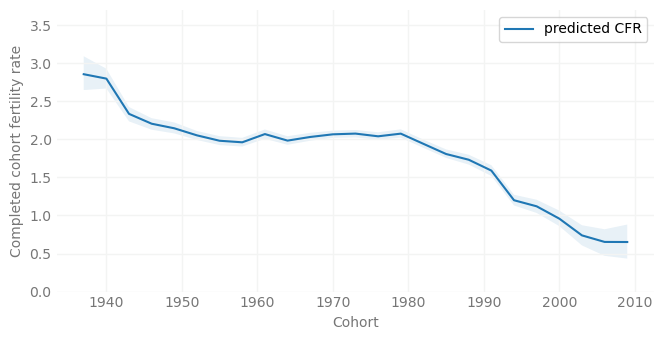

In [50]:
age = 48
cfr_cohort = mean_cumulative_rate[age]
plt.fill_between(low.index, low[age], high[age], alpha=0.1)
cfr_cohort.plot(label="predicted CFR")
decorate(xlabel="Cohort", ylabel="Completed cohort fertility rate", ylim=[0, 3.7])

The model predicts that CFR will decline steeply, starting with women born around 1980, and reaching 0.73 for women born around 2006.

The error bounds show 95% credible intervals that take into account the uncertainty of the estimated coefficients, but we should not take them too seriously because they don't take into account the far larger source of uncertainty -- any number of things that could happen in the future that would affect these outcomes.

I suggest we think of these results as projections rather than predictions -- that is, they show us what we would expect in the future if the structure of the model is appropriate, the estimated parameters are accurate, and nothing changes in the future that substantially affects the outcome.

Considering the structure of the model, the most obvious omission is the possibility of a "rebound" effect, where a cohort that has fewer children when they are young goes on to have more children when they are older, with the effect of closing the CFR gap with previous generations.

Of course that could happen, and possible extensions to the model could either add an interaction term that estimates the rebound in previous generations, or a "what if" parameter that lets us explore the effect of different levels of rebound on future CFR.

We can come back to this question, but first let's consider whether the model has adequately captured the structure of the data.

## Compare model to data

The following function plots observed average parity in each cohort-age group along with the estimates from the model.
Where we have data, we can see if the retrodictions fit it.
And where we are missing data, we can see if the predictions seem plausible.

In [51]:
def plot_cohorts(mean_parity_df, start, end):
    cohorts = mean_parity_df.index[start:end]
    palette = list(sns.color_palette("nipy_spectral", len(cohorts)))

    for i, cohort in enumerate(cohorts):
        mean_parity_df.loc[cohort].plot(
            style="o", color=palette[i], alpha=0.8, label=cohort
        )
        mean_cumulative_rate.loc[cohort].plot(
            style=":", color=palette[i], alpha=0.6, label=""
        )

    decorate(xlabel="Age")

Here are the results for women born in the 1990s and 2000s.

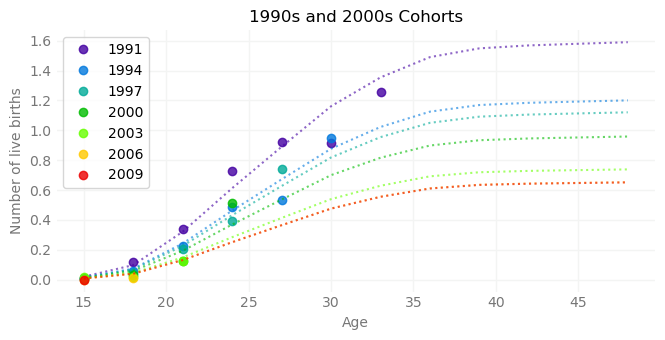

In [52]:
mean_parity_df = sum_df / count_df
plot_cohorts(mean_parity_df, -7, None)
decorate(ylabel="Number of live births", title="1990s and 2000s Cohorts")

Looking at the top line, we can see that the retrodictions for the 1991 cohort fit the data well.
When observed at age 33, the average parity in this group was xx.
The model predicts that their CFR at age 48 will be yy.

In [53]:
mean_parity_df.loc[1991, 33], mean_cumulative_rate.loc[1991, 48]

(1.2542372881355932, 1.5897477130948008)

As expected, predicted CFRs for successive cohorts are lower.
The projections for the last two cohorts overlap because the estimates for their cohort effects are almost the same.

Here are the results for women born in the 1970s and 1980s.

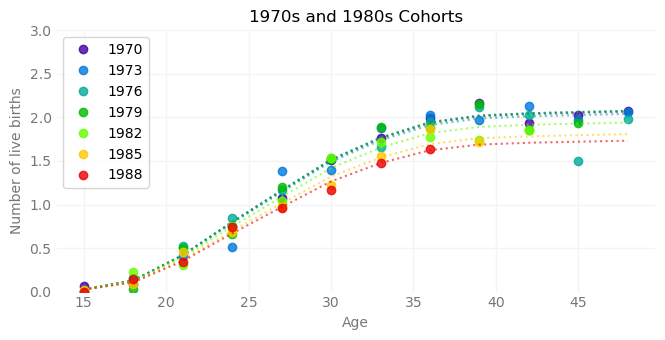

In [54]:
plot_cohorts(mean_parity_df, -14, -7)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1970s and 1980s Cohorts")

The model seems to capture the structure of the data well.
Here are the results for women born in the 1950s and 1960s.

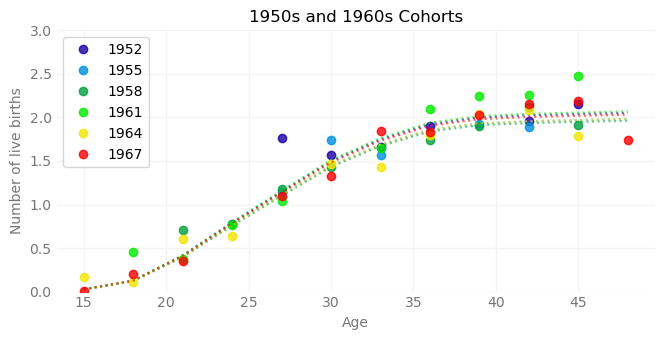

In [55]:
plot_cohorts(mean_parity_df, -20, -14)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1950s and 1960s Cohorts")

We have a little less data about these cohorts -- when they were interviewed, the NSFG did not include women older than 45.
The model fits the data reasonably well.
The estimated CFRs for these cohorts are not very different.

Finally here are the results for women born in the 1940s and the end of the 1930s.

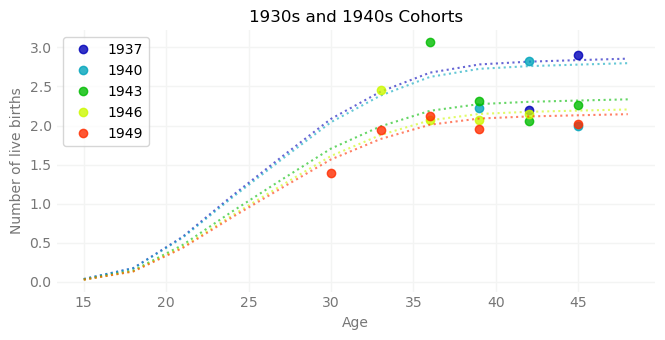

In [56]:
plot_cohorts(mean_parity_df, None, -20)
decorate(ylabel="Number of live births", title="1930s and 1940s Cohorts")

Here we see the decline in total fertility that characterized the end of the baby boom.

Overall, the model seems to capture the structure of the data, and its projections are plausible in the sense that they are based on the assumption that the future will be like the past.

## Compare results to Census data

One other way we can validate this model is to compare its retrodictions to data from another source.
Specifically, we'll use data from [U.S. Census Historical Time Series Tables](https://www.census.gov/data/tables/time-series/demo/fertility/his-cps.html#par_list_2), specifically "Historical Table 2: Distribution of Women Age 40-50 by Number of Children Ever Born and Marital Status: Selected Years, 1970-2022".

The following cell downloads the data.

In [57]:
# Download the Census data

download(
    "https://www2.census.gov/programs-surveys/demo/tables/fertility/time-series/his-cps/h2.xlsx"
)

The following function reads and cleans the data, selecting the column that reports the average number of children borne by women who were age 40-45 when they were interviewed during each year from 1976-2022.

In [58]:
def read_census_data(filename="h2.xlsx"):

    rename_dict = {
        "Unnamed: 0": "Year",
        "Unnamed: 1": "Total",
        "Unnamed: 12": "Rate per 1000",
    }

    df = pd.read_excel(filename, skiprows=6)
    del df["Unnamed: 7"]
    df.rename(columns=rename_dict, inplace=True)
    rows = df.iloc[9:39].drop(36)
    index = rows["Year"].astype(float) * 10000
    rows.index = index.round().astype(int)

    # (Almost) Completed Cohort Fertility Rate
    # Usually age 50, but with this dataset, 40-45 is what we have

    cfr = rows["Rate per 1000"] / 1000
    return cfr

In [59]:
cfr = read_census_data()

The following figure shows the Census data compared to the predicted CFR from the model, shifted so the x-axis shows the year each cohort turns 42 rather than the year they were born.

The results from the model fit the Census data well over the range where they overlap, which should increase confidence in the projections for future cohorts.

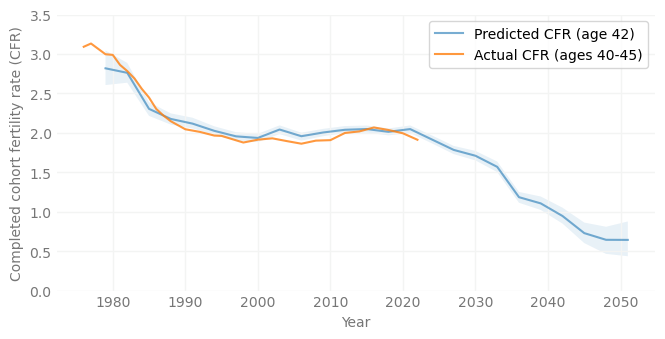

In [60]:
for age in [42]:
    series = mean_cumulative_rate[age]
    shifted = pd.Series(series.values, series.index + age, copy=True)
    plt.fill_between(shifted.index, low[age], high[age], alpha=0.1)
    shifted.plot(alpha=0.6, label=f"Predicted CFR (age {age})")

cfr.plot(alpha=0.8, label="Actual CFR (ages 40-45)")
decorate(ylabel="Completed cohort fertility rate (CFR)", ylim=[0, 3.5])

In summary, the most recent NSFG shows that women born in the 1990s and 2000s are having children at rates substantially slower than previous generations.
But it is not obvious just by looking at the data how substantial these shifts are.
We can get a sense of their magnitude by generating projections that show what effect they would have on cohort completed fertility rates (CFR).

The results show that, unless there is a substantial shift toward higher fertility, starting soon, we should expect a large decline in CFR over the next 30 years, comparable in speed and magnitude to the previous decline at the end of the baby boom.

Of course, predictions 30 years into the future are unlikely to be precise, but if we take the results of the model at face value, it is plausible that CFR will drop below 1.0 between 2040 and 2050, comparable to levels in South Korea now.
At that level, barring large-scale immigration, the population of the United States would decline quickly.